In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 15
nA = 2
seed = get_current_seed()
#seed = 47146882006333120128184314011326542902
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
tmdp_1 = TMDP(river, xi, tau=.5, gamma=gamma, seed=seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Current seed for result reproducibility: 257704463347619984019017397471798436872


In [2]:
q_c = np.zeros((nS, nA))
tmdp.update_tau(.99)
cur_res = curriculum_AC(tmdp, q_c, alpha = 0.08, alpha_pol = 0.03, episodes=1500000, 
                        batch_nS=12, temperature=5., biased=False, lam=0, 
                        epochs=1, use_delta_Q=False, final_temperature=1)


No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 1115 length: 12 #teleports:1103
Time for bound evaluation:  0.10202383995056152
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 2535 length: 12 #teleports:1408
Time for bound evaluation:  0.004000663757324219
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 3524 length: 12 #teleports:977
Time for bound evaluation:  0.002000570297241211
No valid pairs found
[(0.0, 0.99)]
Alpha*: 0.0 tau*: 0.99 Episode: 4871 length: 12 #teleports:1335
Time for bound evaluation:  0.0030014514923095703
[(1, 0.99), (0.0, 0.98881), (1.0, 0.98882)]
Alpha*: 1.0 tau*: 0.98882 Episode: 5694 length: 12 #teleports:811
Got not null reward 10.0!
Time for bound evaluation:  0.0030007362365722656
[(1, 0.98882), (0.0, 0.98759), (1.0, 0.98759)]
Alpha*: 0.0 tau*: 0.98759 Episode: 6522 length: 12 #teleports:816
Time for bound evaluation:  0.0020008087158203125
[(1, 0.98759), (0.0, 0.98631), (1.0, 0.98632)]
Alpha*: 1.0 t

In [3]:
print(get_softmax_policy(cur_res["thetas"][-1]))
print(cur_res["Qs"][-1])
print(get_policy(cur_res["thetas"][-1]))

[[1.00000000e+000 2.10864764e-038]
 [1.00000000e+000 6.83540902e-034]
 [1.00000000e+000 2.48184738e-030]
 [1.00000000e+000 1.39965592e-026]
 [1.00000000e+000 1.48293843e-022]
 [1.00000000e+000 1.10053522e-017]
 [5.70364786e-005 9.99942964e-001]
 [1.87243279e-036 1.00000000e+000]
 [6.67735473e-067 1.00000000e+000]
 [9.88135491e-092 1.00000000e+000]
 [6.73606405e-104 1.00000000e+000]
 [8.86669725e-108 1.00000000e+000]
 [4.91961581e-107 1.00000000e+000]
 [1.53021456e-116 1.00000000e+000]
 [3.64682814e-091 1.00000000e+000]]
[[ 49.99999984  43.2463397 ]
 [ 44.99999983  39.19061362]
 [ 40.49999982  35.59202126]
 [ 36.44999981  32.19477915]
 [ 32.80495468  28.77320159]
 [ 29.52380042  27.27716627]
 [ 26.55244355  38.2729473 ]
 [ 25.43306021  60.00726244]
 [ 38.68317799  89.24609683]
 [ 71.37170597 131.29978077]
 [107.910725   187.92069868]
 [165.21705756 265.15089083]
 [240.54195308 396.24326228]
 [405.91197414 593.64809182]
 [630.66083068 873.84438488]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [

In [4]:
res = bellman_optimal_q(mdp.env.P_mat, mdp.env.reward, mdp.gamma)
Q = res["Q"]
print(Q)
d = compute_d_from_tau(mdp.env.mu, mdp.env.P_mat, mdp.xi, get_policy(Q), mdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_softmax_policy(cur_res["thetas"][-1]), tmdp.gamma, 0.)
d_q = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(q_c), tmdp.gamma, 0.)

delta_pol = get_policy(Q)-get_policy(get_softmax_policy(cur_res["thetas"][-1]))
print(delta_pol)
V = compute_V_from_Q(Q, get_softmax_policy(cur_res["thetas"][-1]))
r_s_a = compute_r_s_a(mdp.env.P_mat, mdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, mdp.gamma)
j_curr = compute_j(r_s_a, get_policy(get_softmax_policy(cur_res["thetas"][-1])), d_curr, tmdp.gamma)
j_q_curr = compute_j(r_s_a, get_policy(q_c), d_q, tmdp.gamma)
j_exp = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)
print("expected performance: ",j_exp)
print("curriculum performance: ", j_curr)
print("Q curriculum performance: ",j_q_curr)

[[ 49.99999551  43.64999596]
 [ 44.99999596  39.73499632]
 [ 40.49999636  35.76149669]
 [ 36.44999673  32.18534702]
 [ 32.80499705  29.6973722 ]
 [ 29.52449735  32.2302746 ]
 [ 29.00724714  43.97583974]
 [ 39.57825577  64.17837661]
 [ 57.76053895  94.68232506]
 [ 85.21409256 139.91783603]
 [125.92605242 206.81776075]
 [186.13598467 305.71690659]
 [275.14521593 451.91177272]
 [406.72059545 668.01812565]
 [601.21631308 987.46769745]]
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [-1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
optimal performance:  213.31146154464213
expected performance:  213.13101772015557
curriculum performance:  213.07834470201638
Q curriculum performance:  213.07855128449287


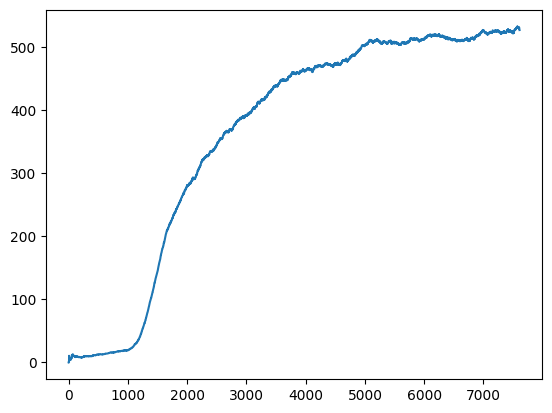

In [5]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 500:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-499:idx+1]
    average_reward.append(np.average(avg_list)/12)
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)